1. Imported Required Libriraries


- Imported essential libraries here for the file handling (os) and deep learning (torch, transformers).

- Loading datasets (ImageFolder), preprocess images (transforms), and use Vision Transformers (ViTForImageClassification).

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from transformers import ViTForImageClassification, ViTConfig

2. Dataset Import and Setup

- Here we imported OxfordIIITPet dataset and defined a function to load it with preprocessing (resizing and converting to tensors as per our requirement).

- Load Dataset: Downloaded and then prepared the Oxford-IIIT Pet dataset & then we created a DataLoader with a batch size of 8 for training.

In [ ]:
from torchvision.datasets import OxfordIIITPet
import os

def load_oxford_pet_dataset(data_dir, batch_size):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = OxfordIIITPet(
        root=data_dir,
        split='trainval',
        download=True,
        transform=transform,
        target_transform=None
    )

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

data_dir = os.path.expanduser('~/.datasets/oxford_iiit_pet')
train_loader = load_oxford_pet_dataset(data_dir, batch_size=8)



3. Data Preprocessing
- Preprocessing Pipeline: Here we applied random augmentations like (flipping, rotation, color jitter), resizing, and normalization to images.

- Dataset Loading: Here we downloaded and then loaded the Oxford-IIIT Pet dataset with preprocessing.

- Data Cleaning: here we filtered out corrupt samples from the dataset.

- Class Balancing: Computeed the class weights for imbalanced classes and createed a WeightedRandomSampler for balanced sampling.

- DataLoader: Used the sampler to create a balanced DataLoader for training as we can see below.

In [ ]:
from collections import Counter
from torchvision.transforms import Normalize, Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize, ToTensor
from torch.utils.data import WeightedRandomSampler

# Normalize images
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
transform = Compose([
    RandomHorizontalFlip(),
    RandomRotation(10),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

# Define dataset directory
data_dir = os.path.expanduser('~/.datasets/oxford_iiit_pet')

# Load dataset
dataset = OxfordIIITPet(
    root=data_dir,
    split='trainval',
    download=True,
    transform=transform
)

# Check and filter corrupt samples
cleaned_dataset = [dataset[i] for i in range(len(dataset)) if dataset[i]]

# Handle imbalanced classes
labels = [sample[1] for sample in cleaned_dataset]
class_counts = Counter(labels)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for _, label in cleaned_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(cleaned_dataset), replacement=True)

# Create DataLoader with the sampler
train_loader = DataLoader(cleaned_dataset, batch_size=8, sampler=sampler)

print("Cleaned and balanced dataset ready!")

Cleaned and balanced dataset ready!


4. Exploratory Data Analysis

- Dataset Summary: Printed the total number of samples and class-wise label distribution.

- Label Distribution Visualization: Ploted a bar chart showing the frequency of each class as below.

- Sample Images Display: Displayed 5 sample images of the dataset which are cats in this case, along with their labels.

- Image Dimension Statistics: Calculated and printed the average height and width of the images in the dataset which is 224.

Total number of samples: 3680
Label distribution: Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 8: 100, 9: 100, 10: 100, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 18: 100, 19: 100, 20: 100, 21: 100, 23: 100, 24: 100, 25: 100, 26: 100, 27: 100, 28: 100, 29: 100, 30: 100, 31: 100, 33: 100, 34: 100, 35: 100, 36: 100, 32: 99, 7: 96, 12: 96, 22: 96, 11: 93})


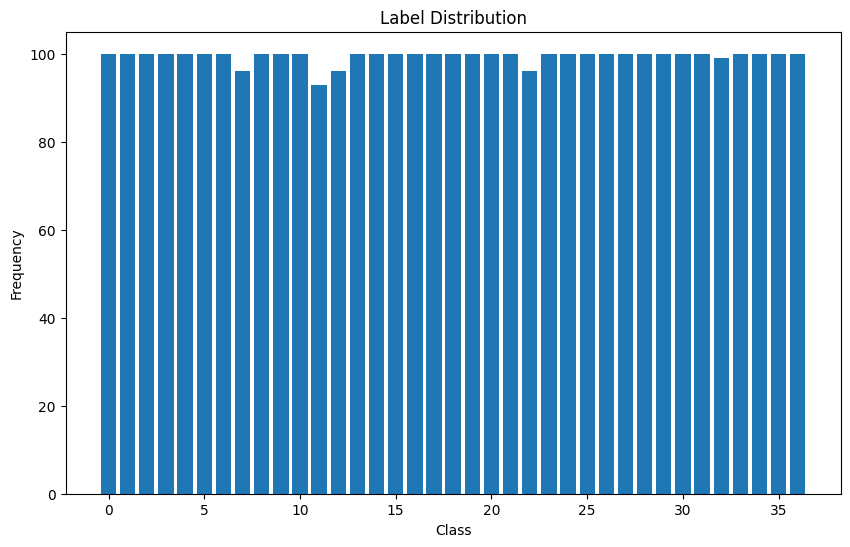

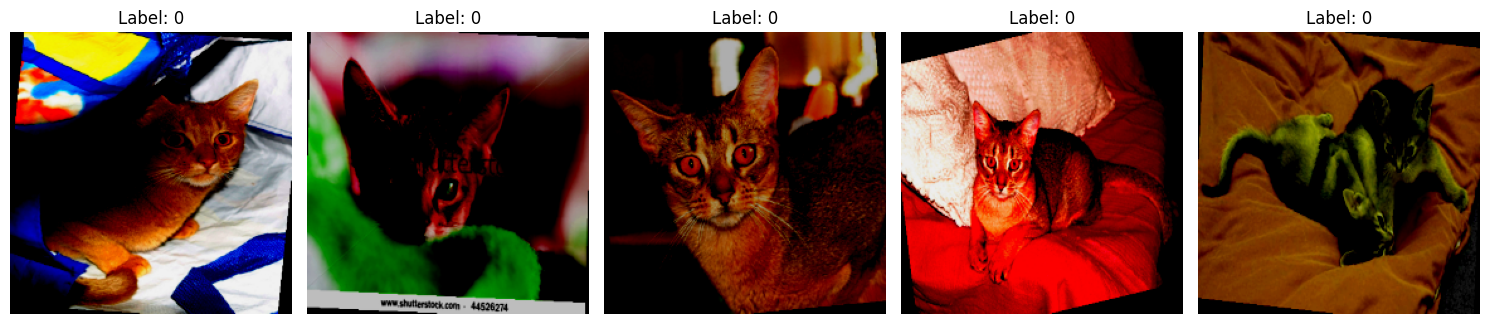

Average height: 224.00
Average width: 224.00


In [ ]:
# EDA Section: Exploratory Data Analysis
import matplotlib.pyplot as plt
from collections import Counter

# Dataset summary
dataset = train_loader.dataset
print(f"Total number of samples: {len(dataset)}")

# Label distribution
labels = [sample[1] for sample in dataset]
label_counts = Counter(labels)
print(f"Label distribution: {label_counts}")

# Visualize label distribution
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

# Display sample images with labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    image, label = dataset[i]
    ax.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Image dimension statistics
image_shapes = [sample[0].shape for sample in dataset]
heights = [shape[1] for shape in image_shapes]
widths = [shape[2] for shape in image_shapes]

print(f"Average height: {sum(heights) / len(heights):.2f}")
print(f"Average width: {sum(widths) / len(widths):.2f}")

5. Initialization of the Model

- Model Initialization: Defineed a smaller Vision Transformer (ViT) model with reduced hidden size, fewer layers, and fewer attention heads for simplicity.

- Classification Head: Replaceed the default classifier with a custom linear layer for 37 pet breed classes.

In [ ]:

def initialize_simple_vit(num_classes):
    from transformers import ViTForImageClassification, ViTConfig

    config = ViTConfig(
        hidden_size=192,  # Smaller model
        num_hidden_layers=4,  # Fewer layers
        num_attention_heads=3,
        intermediate_size=768
    )
    model = ViTForImageClassification(config)
    model.classifier = nn.Linear(config.hidden_size, num_classes)
    return model

num_classes = 37  # Total number of pet breeds
model = initialize_simple_vit(num_classes)


6. ViT Model Growth by adding transformer layers

- Model Growth: Expanded the Vision Transformer (ViT) by adding additional transformer layers to the model configuration.

- Weight Transfer & Initialization: Transfered the pretrained weights to the existing layers and initialized new layers with random weights.

In [ ]:
def grow_model(model, additional_layers):
    """
    Grows the Vision Transformer (ViT) model by adding additional transformer layers.

    Args:
        model: The current ViT model.
        additional_layers: Number of additional transformer layers to add.

    Returns:
        new_model: The expanded ViT model with additional layers.
    """
    from transformers import ViTForImageClassification, ViTConfig

    # Clone the current configuration
    config = model.config

    # Increase the number of hidden layers
    config.num_hidden_layers += additional_layers

    # Create a new ViT model with the updated configuration
    new_model = ViTForImageClassification(config)

    # Match the output size of the classifier with the current number of classes
    new_model.classifier = nn.Linear(config.hidden_size, model.classifier.out_features)

    # Transfer pretrained weights
    new_model.load_state_dict(model.state_dict(), strict=False)

    # Initialize new layers with random weights
    for i in range(config.num_hidden_layers - additional_layers, config.num_hidden_layers):
        torch.nn.init.xavier_uniform_(new_model.vit.encoder.layer[i].attention.attention.query.weight)
        torch.nn.init.xavier_uniform_(new_model.vit.encoder.layer[i].attention.attention.key.weight)
        torch.nn.init.xavier_uniform_(new_model.vit.encoder.layer[i].attention.attention.value.weight)
        torch.nn.init.xavier_uniform_(new_model.vit.encoder.layer[i].attention.output.dense.weight)

    return new_model


GPU configuration for project

In [ ]:

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


7. Training Loop with Dynamic Model Growth and Learning Rate Adjustment

- Training Setup: Initialized training parameters, including the loss function (CrossEntropyLoss), optimizer (Adam), and learning rate scheduler (ReduceLROnPlateau).

- Training Loop: For each epoch, we trained the model, calculated the loss and accuracy, and adjusted the learning rate based on the loss.

- Model Growth: Every epochs_per_growth epochs, the model is expanded by adding additional transformer layers, followed by retraining the new layers.

- Metrics Storage: Tracked loss, accuracy, and time per epoch for visualization or analysis of the model we got 94% accuracy as we can observe below.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Initialize storage for metrics
epoch_losses = []
epoch_accuracies = []
epoch_times = []

# Number of epochs after which the model grows
epochs_per_growth = 2
additional_layers = 2

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Define scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Ensure the model is moved to the correct device
model.to(device)

for epoch in range(20):  # Total training epochs
    model.train()
    running_loss = 0.0
    start_time = time.time()  # Track start time for the epoch

    correct = 0
    total = 0

    for images, targets in train_loader:
        # Move images and targets to the correct device
        images = images.to(device)
        labels = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Track accuracy during training
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_time = time.time() - start_time

    # Store metrics
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    epoch_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f}s")

    # Adjust learning rate
    scheduler.step(epoch_loss)

    # Grow the model and reset optimizer
    if (epoch + 1) % epochs_per_growth == 0:
        print(f"Growing model at epoch {epoch + 1}")
        model = grow_model(model, additional_layers)  # Modify the model
        model.to(device)  # Move the new model to the correct device
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        # Additional training for new layers
        additional_epochs = 2
        for _ in range(additional_epochs):
            for images, targets in train_loader:
                images = images.to(device)
                labels = targets.to(device)

                optimizer.zero_grad()
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()


Epoch [1/20], Loss: 3.6380, Accuracy: 4.24%, Time: 12.04s
Epoch [2/20], Loss: 3.5742, Accuracy: 5.27%, Time: 11.66s
Growing model at epoch 2
Epoch [3/20], Loss: 3.4721, Accuracy: 6.85%, Time: 15.77s
Epoch [4/20], Loss: 3.4219, Accuracy: 8.78%, Time: 15.85s
Growing model at epoch 4
Epoch [5/20], Loss: 3.2687, Accuracy: 12.12%, Time: 20.68s
Epoch [6/20], Loss: 3.2284, Accuracy: 12.88%, Time: 20.74s
Growing model at epoch 6
Epoch [7/20], Loss: 2.9758, Accuracy: 18.56%, Time: 25.32s
Epoch [8/20], Loss: 2.9429, Accuracy: 19.05%, Time: 25.22s
Growing model at epoch 8
Epoch [9/20], Loss: 2.6212, Accuracy: 28.42%, Time: 30.11s
Epoch [10/20], Loss: 2.4162, Accuracy: 33.80%, Time: 29.55s
Growing model at epoch 10
Epoch [11/20], Loss: 1.9733, Accuracy: 46.74%, Time: 34.62s
Epoch [12/20], Loss: 1.7714, Accuracy: 53.10%, Time: 35.01s
Growing model at epoch 12
Epoch [13/20], Loss: 1.1913, Accuracy: 69.21%, Time: 39.36s
Epoch [14/20], Loss: 0.9838, Accuracy: 74.70%, Time: 39.27s
Growing model at epoc

8. Visualization

- Loss Curve: Here we showed how the loss changes across epochs.

- Accuracy Curve: Displayed the training accuracy progression.

- Training Time Curve: Illustrated the time taken for each epoch.

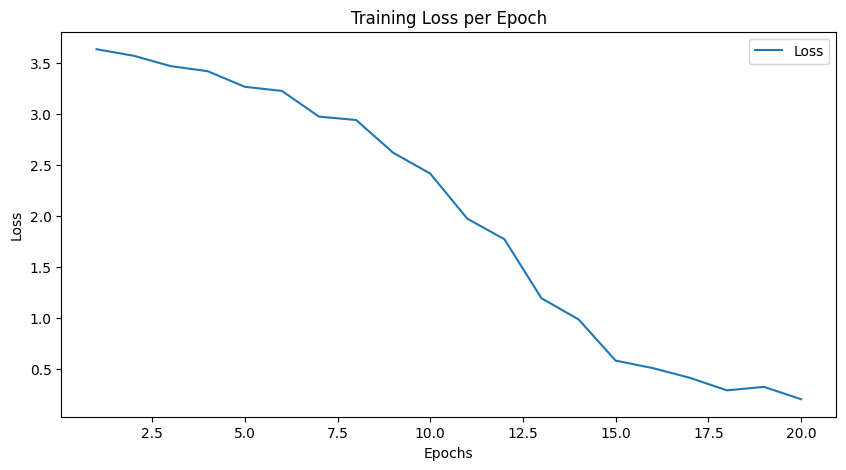

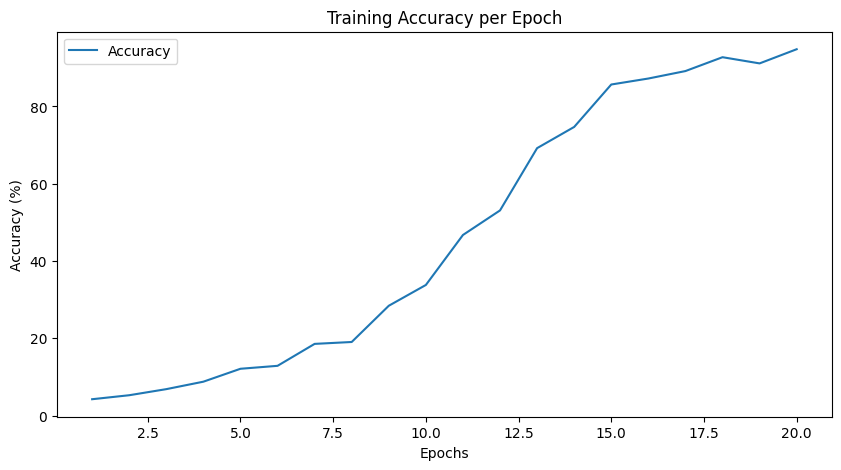

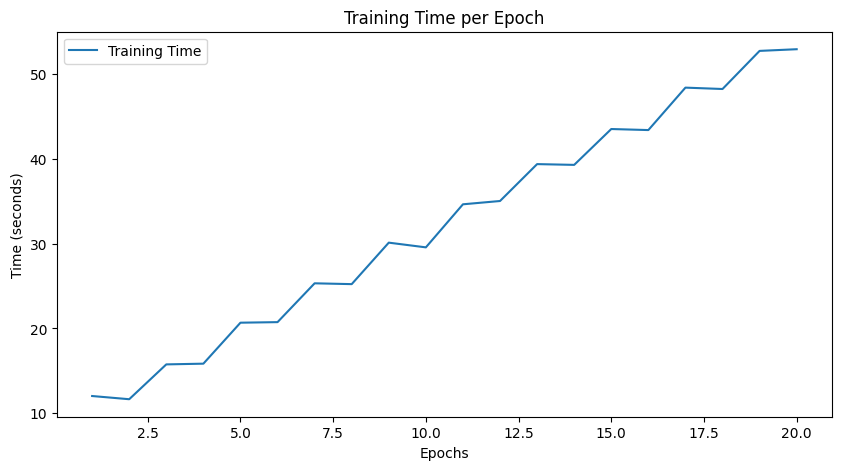

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.show()

# Plot Training Time Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_times) + 1), epoch_times, label='Training Time')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()


9. Model Evaluation

- Here we got 96.22 % of accuracy.

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            labels = targets.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

evaluate_model(model, train_loader)

Accuracy: 96.22%


10. CNN model

-  Similar to above, we implemented CNN model for comparing the both model accuracies for getting better performing model

Epoch [1/20], Loss: 3.3277, Accuracy: 12.61%, Time: 16.76s
Epoch [2/20], Loss: 2.4050, Accuracy: 39.16%, Time: 16.52s
Epoch [3/20], Loss: 1.4989, Accuracy: 63.72%, Time: 16.60s
Epoch [4/20], Loss: 0.8516, Accuracy: 81.39%, Time: 16.50s
Epoch [5/20], Loss: 0.4557, Accuracy: 90.46%, Time: 16.56s
Epoch [6/20], Loss: 0.2367, Accuracy: 95.22%, Time: 18.84s
Epoch [7/20], Loss: 0.1002, Accuracy: 98.37%, Time: 16.49s
Epoch [8/20], Loss: 0.0630, Accuracy: 98.78%, Time: 16.54s
Epoch [9/20], Loss: 0.0361, Accuracy: 99.32%, Time: 16.69s
Epoch [10/20], Loss: 0.0148, Accuracy: 99.76%, Time: 16.91s
Epoch [11/20], Loss: 0.0200, Accuracy: 99.67%, Time: 16.50s
Epoch [12/20], Loss: 0.0236, Accuracy: 99.62%, Time: 16.67s
Epoch [13/20], Loss: 0.0063, Accuracy: 99.89%, Time: 16.54s
Epoch [14/20], Loss: 0.0380, Accuracy: 99.32%, Time: 16.53s
Epoch [15/20], Loss: 0.0329, Accuracy: 99.13%, Time: 16.56s
Epoch [16/20], Loss: 0.0238, Accuracy: 99.51%, Time: 16.56s
Epoch [17/20], Loss: 0.0058, Accuracy: 99.89%, Ti

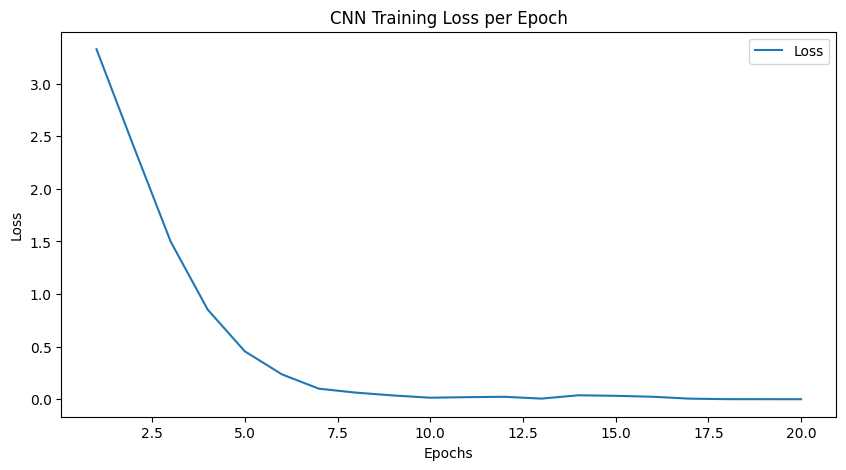

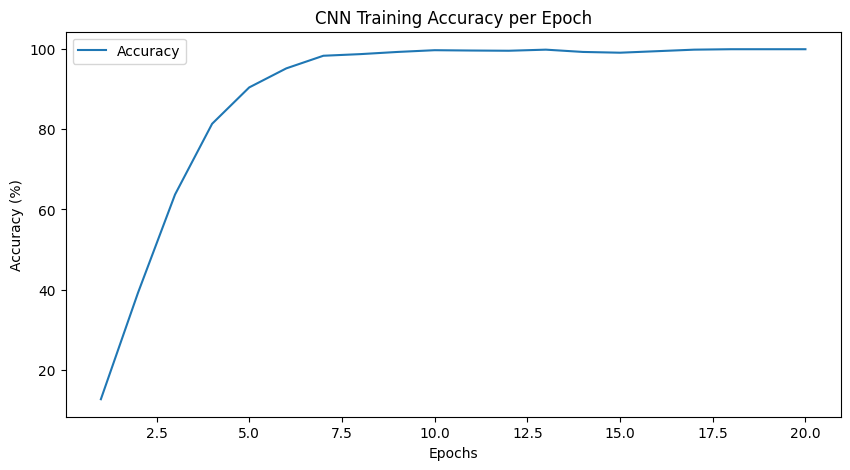

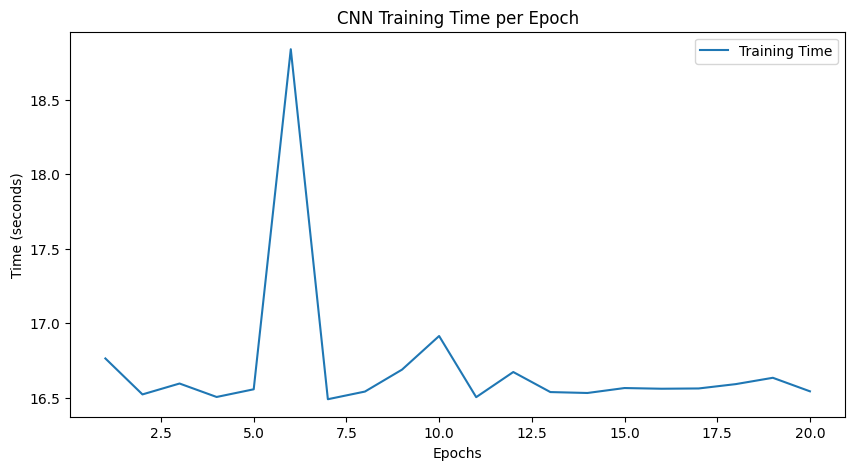

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import matplotlib.pyplot as plt

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the model
num_classes = 37
cnn_model = SimpleCNN(num_classes).to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Initialize storage for metrics
cnn_epoch_losses = []
cnn_epoch_accuracies = []
cnn_epoch_times = []

# Training loop
epochs = 20
for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    start_time = time.time()  # Track start time for the epoch

    correct = 0
    total = 0

    for images, targets in train_loader:
        # Move images and targets to the correct device
        images = images.to(device)
        labels = targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(images)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Track accuracy during training
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_time = time.time() - start_time

    # Store metrics
    cnn_epoch_losses.append(epoch_loss)
    cnn_epoch_accuracies.append(epoch_accuracy)
    cnn_epoch_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f}s")

    # Adjust learning rate
    scheduler.step(epoch_loss)

# Visualizations
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cnn_epoch_losses) + 1), cnn_epoch_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Training Loss per Epoch')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cnn_epoch_accuracies) + 1), cnn_epoch_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('CNN Training Accuracy per Epoch')
plt.legend()
plt.show()

# Plot Training Time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cnn_epoch_times) + 1), cnn_epoch_times, label='Training Time')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('CNN Training Time per Epoch')
plt.legend()
plt.show()


11. Vision Transformer Model.

Using device: cuda
Class distribution: Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 8: 100, 9: 100, 10: 100, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 18: 100, 19: 100, 20: 100, 21: 100, 23: 100, 24: 100, 25: 100, 26: 100, 27: 100, 28: 100, 29: 100, 30: 100, 31: 100, 33: 100, 34: 100, 35: 100, 36: 100, 32: 99, 7: 96, 12: 96, 22: 96, 11: 93})
Epoch [1/20], Loss: 3.7613, Accuracy: 2.92%, Time: 178.81s
Epoch [2/20], Loss: 3.7011, Accuracy: 2.51%, Time: 180.16s
Epoch [3/20], Loss: 3.6772, Accuracy: 2.34%, Time: 179.61s
Epoch [4/20], Loss: 3.6435, Accuracy: 3.77%, Time: 182.99s
Epoch [5/20], Loss: 3.6530, Accuracy: 2.62%, Time: 178.95s
Epoch [6/20], Loss: 3.6403, Accuracy: 3.06%, Time: 180.11s
Epoch [7/20], Loss: 3.6559, Accuracy: 2.65%, Time: 179.38s
Epoch [8/20], Loss: 3.6557, Accuracy: 2.07%, Time: 179.62s
Epoch [9/20], Loss: 3.6480, Accuracy: 2.51%, Time: 179.70s
Epoch [10/20], Loss: 3.6095, Accuracy: 2.96%, Time: 178.98s
Epoch [11/20], Loss: 3.5913, Accuracy: 3.8

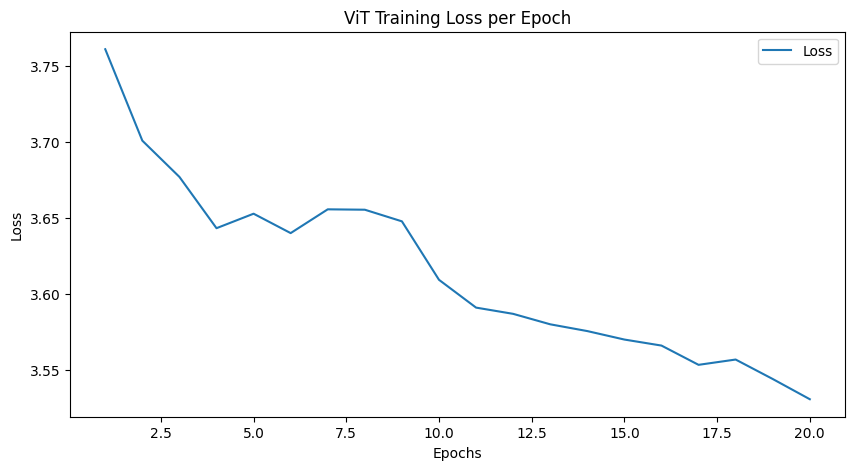

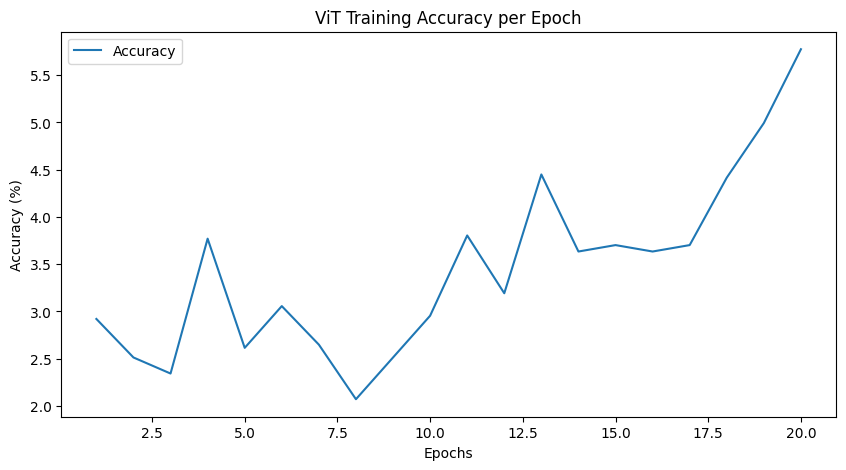

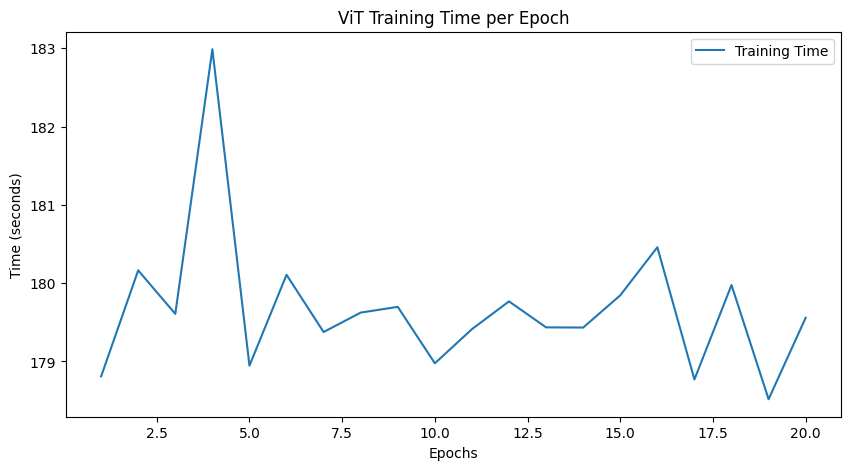

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation, ColorJitter
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
from transformers import ViTForImageClassification, ViTConfig

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preprocessing
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
transform = Compose([
    RandomHorizontalFlip(),
    RandomRotation(10),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

# Load dataset
data_dir = '~/.datasets/oxford_iiit_pet'
dataset = OxfordIIITPet(root=data_dir, split='trainval', download=True, transform=transform)

# Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Check class distribution
from collections import Counter
labels = [dataset[i][1] for i in range(len(dataset))]
label_counts = Counter(labels)
print(f"Class distribution: {label_counts}")

# Define Full Vision Transformer Model
def initialize_full_vit(num_classes):
    config = ViTConfig(
        hidden_size=768,  # Larger hidden size for Full ViT
        num_hidden_layers=12,  # Full depth
        num_attention_heads=12,  # Number of attention heads
        intermediate_size=3072  # Intermediate layer size
    )
    model = ViTForImageClassification(config)
    model.classifier = nn.Linear(config.hidden_size, num_classes)  # Match output to dataset classes
    return model

# Initialize the Full ViT
num_classes = 37  # Number of classes in the Oxford-IIIT Pet Dataset
vit_model = initialize_full_vit(num_classes)
vit_model.to(device)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training loop
epochs = 20
vit_losses = []
vit_accuracies = []
vit_times = []

for epoch in range(epochs):
    vit_model.train()
    running_loss = 0.0
    start_time = time.time()

    correct = 0
    total = 0

    for images, targets in train_loader:
        images = images.to(device)
        labels = targets.to(device)

        optimizer.zero_grad()
        outputs = vit_model(images).logits  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_time = time.time() - start_time

    # Store metrics
    vit_losses.append(epoch_loss)
    vit_accuracies.append(epoch_accuracy)
    vit_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f}s")

    # Adjust learning rate
    scheduler.step(epoch_loss)

# Evaluation
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            labels = targets.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate on training and validation datasets
train_accuracy = evaluate_model(vit_model, train_loader)
val_accuracy = evaluate_model(vit_model, val_loader)

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Visualizations
# Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(vit_losses) + 1), vit_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ViT Training Loss per Epoch')
plt.legend()
plt.show()

# Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(vit_accuracies) + 1), vit_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('ViT Training Accuracy per Epoch')
plt.legend()
plt.show()

# Training Time Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(vit_times) + 1), vit_times, label='Training Time')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('ViT Training Time per Epoch')
plt.legend()
plt.show()


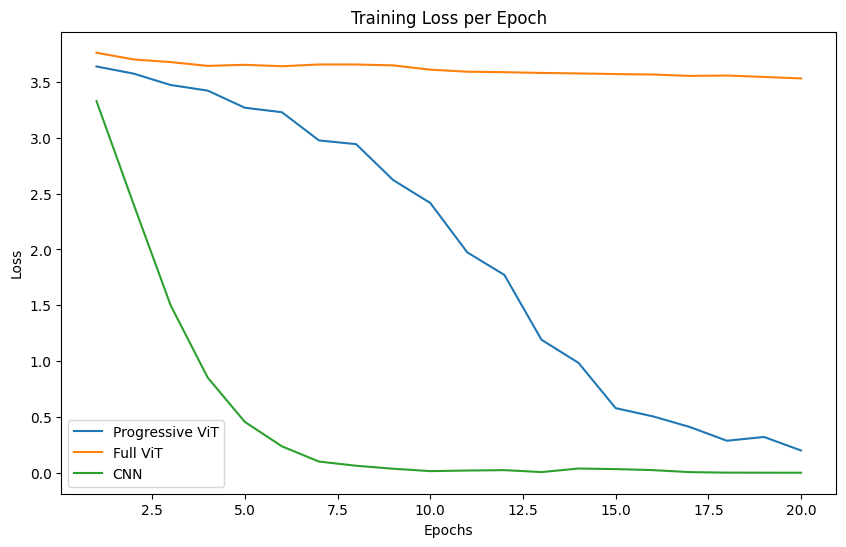

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Progressive ViT')
plt.plot(range(1, len(vit_losses) + 1), vit_losses, label='Full ViT')
plt.plot(range(1, len(cnn_epoch_losses) + 1), cnn_epoch_losses, label='CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()


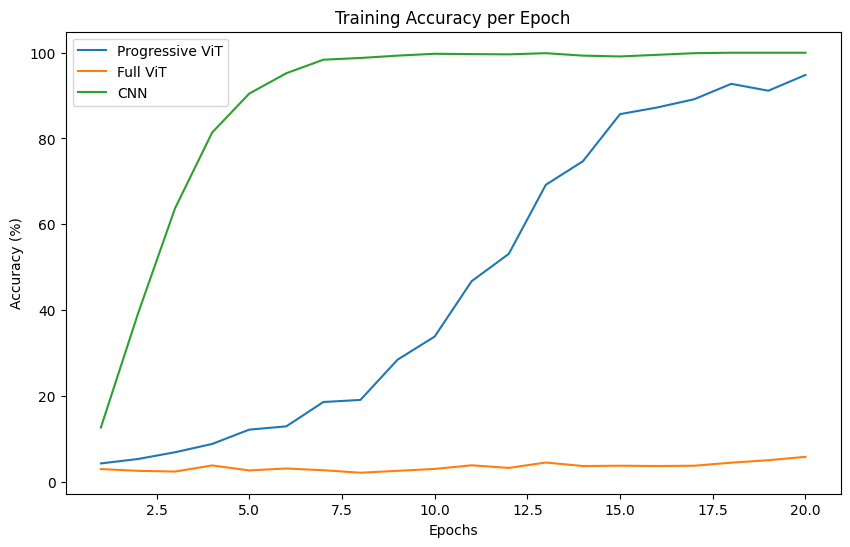

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies, label='Progressive ViT')
plt.plot(range(1, len(vit_accuracies) + 1), vit_accuracies, label='Full ViT')
plt.plot(range(1, len(cnn_epoch_accuracies) + 1), cnn_epoch_accuracies, label='CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.show()


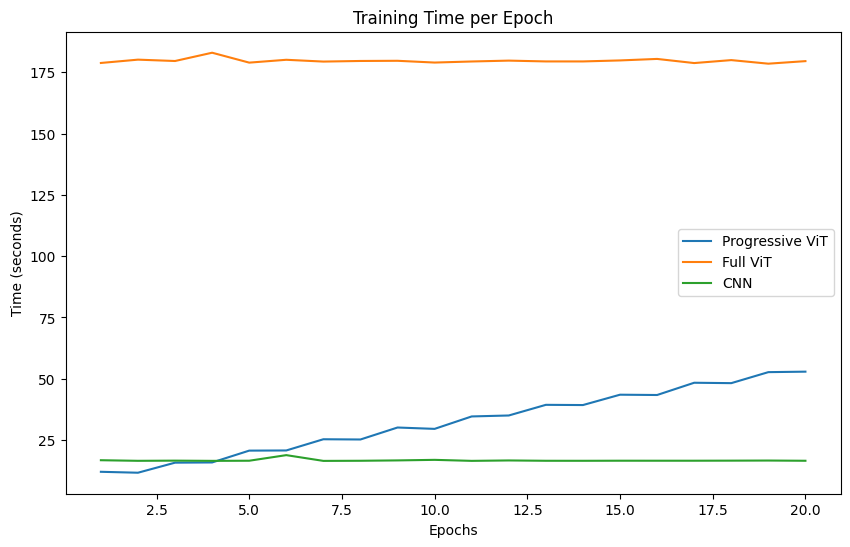

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_times) + 1), epoch_times, label='Progressive ViT')
plt.plot(range(1, len(vit_times) + 1), vit_times, label='Full ViT')
plt.plot(range(1, len(cnn_epoch_times) + 1), cnn_epoch_times, label='CNN')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()
